# IBM Credit Card Fraud Detection
By Jasmine Zhang

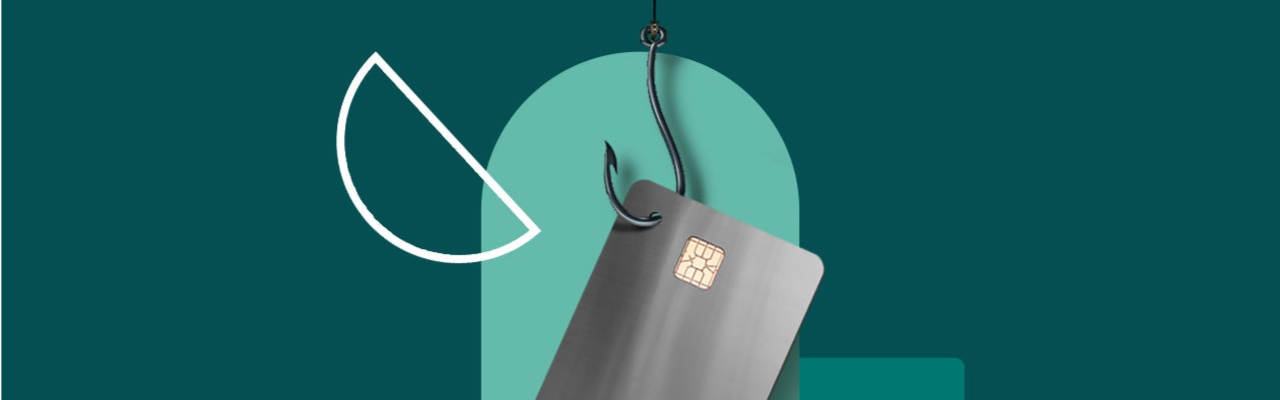

## One-Page Summary

#### Dataset:

The dataset presents an extensive collection of around 24.4 million credit card transactions, sourced from IBM's financial database. Capturing a wide spectrum of user interactions, the data provides a detailed snapshot of transaction behaviors, patterns, and potential vulnerabilities. 
Details include: **<span style="color:#007d79;"> User&card info, time&amount of transactions, merchant details, fraud detection flag</span>**.

#### Methodology:
- **Exploratory Data Analysis (EDA):** Analyze trends, gain insights into fraudulant transaction behaviors and system vulnerabilities.
- **Predictive Modelling:** Develop models based on past fraudulent transactions to predict and mitigate future fraud, aiming to enhance overall security and user trust.

#### Project Highlight:

**[1. Data Overview](#data_overview)**

Delve into the dataset's structure and distribution, inspecting its types of data and missing values that could impact the analysis.


**[2. Data Cleaning](#data_cleaning)**

Address inconsistencies and missing values to ensure the dataset's integrity, and remove redundancies to streamline the dataset, making it suitable for accurate and reliable analysis.

**[3. Exploratory Data Analysis](#eda)**

Examine patterns and trends of fraud transactions by visualizing fraud distribution on various metrics. From the EDA, we identified that certain variables significantly influence the fraud rate, and therefore, incorporated them into our predictive modeling:

* **[Transaction Amount:](#amount)**
Fraud is predominantly observed in transactions of smaller values.

* **[Geographical Distribution:](#geo)**
The distribution of fraud cases shows clear geographical differences.

* **[Time Variation:](#time)**
The distribution of fraud cases displays distinct time variations (By year, day of week, hour of day)

* **[Transaction Method:](#chip)**
Online transactions present the most significant vulnerability to fraud.


**[4. Fraud Detection with Machine Learning](#ml)**

* **[Data Preprocessing:](#data_preprocessing)**
Preprocessed the data to maintain consistency and balance, and then set up for further analysis.

* **[Model Optimization:](#randomforest)**
Used Random Forest model, made fine-tuning adjustments for better performance, and achieved a **<span style="color:#007d79;">78%</span>** success rate in correctly identifying fraud transactions.

**[5. Insights & Recommendations](#insights)**
* Through our analysis, we pinpointed three crucial variables influencing fraudulent activities: **<span style="color:#007d79;">the type of merchant (MCC), transaction amount, and the nature of the transaction (online vs. physical)</span>**. Recognizing these factors can guide financial institutions in refining their fraud prevention strategies.

## 1. Data Overview <a class="anchor"  id="data_overview"></a>

In [1]:
# Import necessary modules
import numpy as np 
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder

In [2]:
df = pd.read_csv('/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


In [4]:
df.head(10)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
5,0,0,2002,9,3,13:53,$86.19,Swipe Transaction,-7146670748125200898,Monterey Park,CA,91755.0,5970,NaN,No
6,0,0,2002,9,4,05:51,$93.84,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
7,0,0,2002,9,4,06:09,$123.50,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
8,0,0,2002,9,5,06:14,$61.72,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
9,0,0,2002,9,5,09:35,$57.10,Swipe Transaction,4055257078481058705,La Verne,CA,91750.0,7538,NaN,No


In [5]:
# Check the number of fraudulent transactions
df['Is Fraud?'].value_counts()

Is Fraud?
No     24357143
Yes       29757
Name: count, dtype: int64

In [6]:
# Check missing value by column
df.isnull().sum()

User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use Chip                 0
Merchant Name            0
Merchant City            0
Merchant State     2720821
Zip                2878135
MCC                      0
Errors?           23998469
Is Fraud?                0
dtype: int64

## 2. Data Cleaning <a class="anchor"  id="data_cleaning"></a>

### (1) Amount <a class="anchor"  id="subsection1"></a>

In [7]:
df.Amount.head(5)

0    $134.09
1     $38.48
2    $120.34
3    $128.95
4    $104.71
Name: Amount, dtype: object

In [8]:
# We need to strip the '$' from the Amount to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

In [9]:
# Now, we have transformed the datatype of Amount from object to float
df.Amount.head(5)

0    134.09
1     38.48
2    120.34
3    128.95
4    104.71
Name: Amount, dtype: float64

### (2) Time

In [10]:
df.Time.head(5)

0    06:21
1    06:42
2    06:22
3    17:45
4    06:23
Name: Time, dtype: object

In [11]:
# Extract the hour and minute to perform a more refined time series analysis
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]
df = df.drop(['Time'],axis=1)

### (3) Fraud

In [12]:
# change the is fraud column to binary 
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

## 3. Exploratory Data Analysis <a class="anchor"  id="eda"></a>

To gain relevant insights into fraud cases, We subset this group of data for Exploratory Data Analysis. This targeted approach allows for a more in-depth analysis and understanding of the underlying patterns and behaviors associated with fraud.

In [13]:
fraud_data = df[df['Is Fraud?'] == 1]

### (1) Transaction Amount <a class="anchor"  id="amount"></a>

/tmp/ipykernel_20/1091417653.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud_data['Amount'].astype(float), kde=False, bins=80)


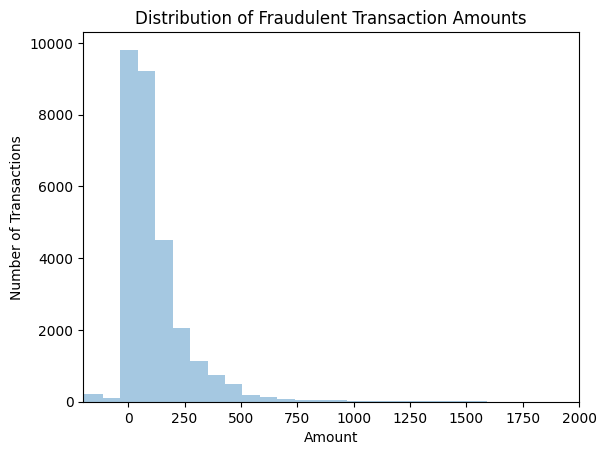

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(fraud_data['Amount'].astype(float), kde=False, bins=80)
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim(-200, 2000)
plt.show()


The majority of fraudulent transactions' amount range from 0 to 250, indicating a prevalence of fraud in smaller-value transactions.

### (2) Geographical Distribution <a class="anchor"  id="geo"></a>

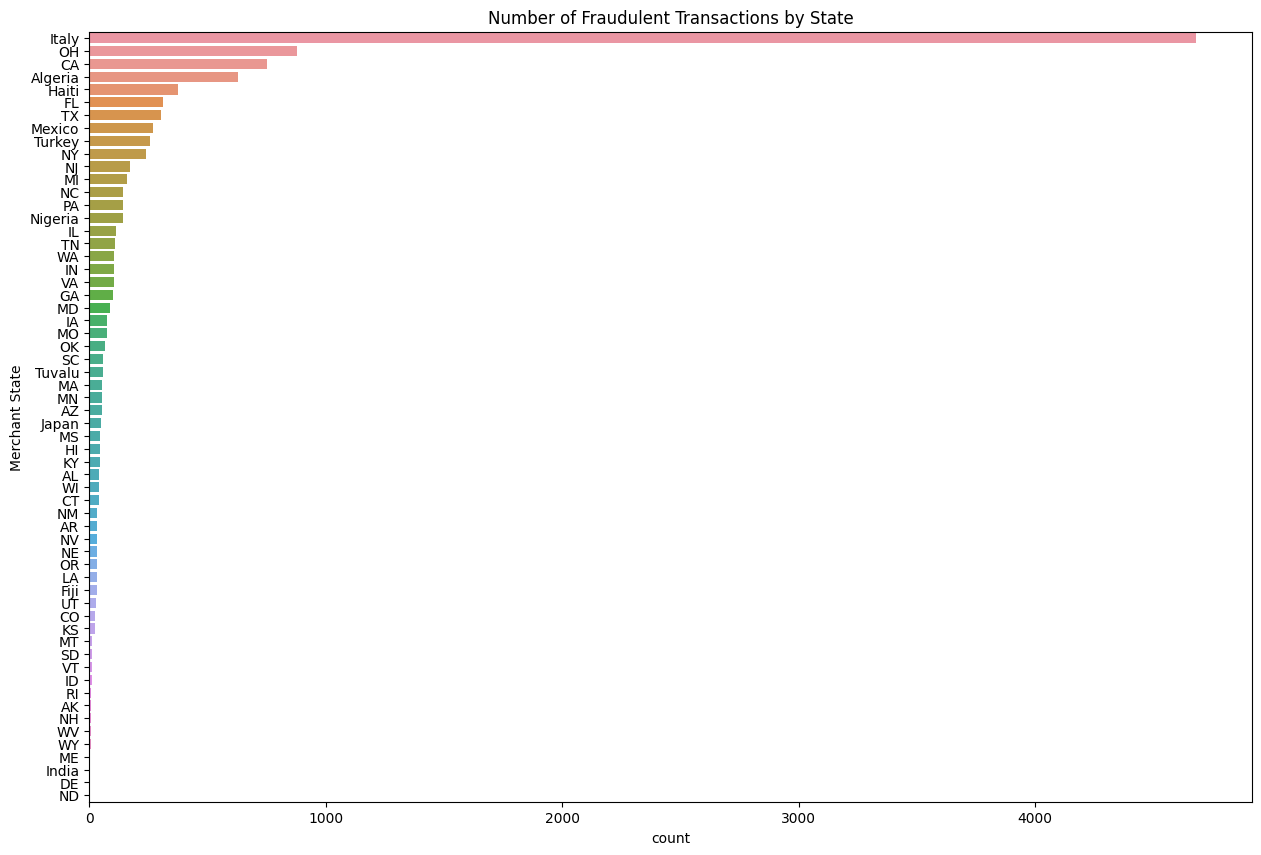

In [15]:
plt.figure(figsize=(15, 10))  
sns.countplot(data=fraud_data, y='Merchant State', order=fraud_data['Merchant State'].value_counts().index)
plt.title('Number of Fraudulent Transactions by State')
plt.show()

The State contains a mix of US states and other countries, highlighting clear geographical distinctions.

- At the country level, Italy, Algeria, Haiti, and Mexico are the major hotspot for fraudulent activities. 
- Among US states, Ohio, California, and Florida records the highest incidences of fraud.

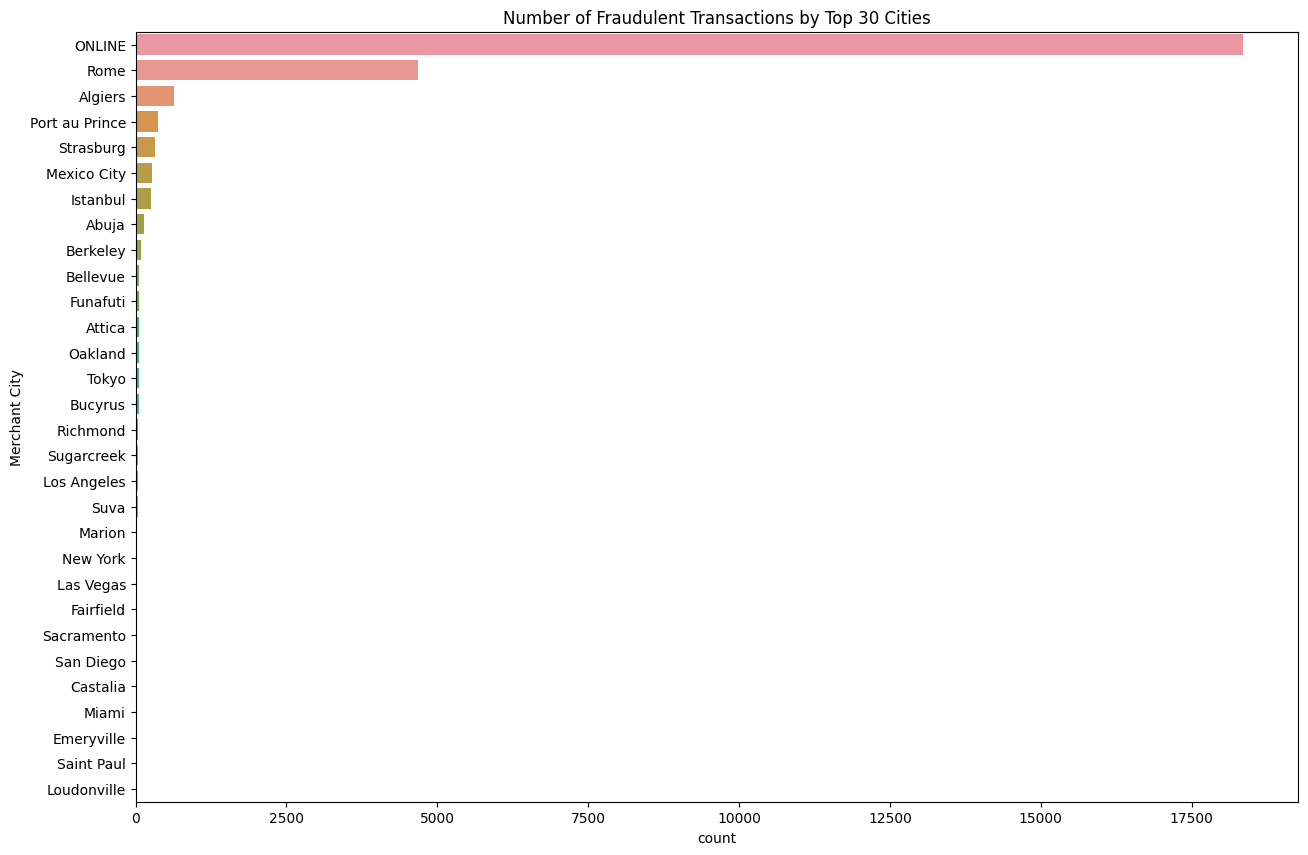

In [16]:
plt.figure(figsize=(15, 10))
top_cities = fraud_data['Merchant City'].value_counts().head(30).index
sns.countplot(data=fraud_data, y='Merchant City', order=top_cities)
plt.title('Number of Fraudulent Transactions by Top 30 Cities')
plt.show()


Online transactions are the primary venues where fraud predominantly occurs. Additionally, cities such as Rome, Algiers, and Port-au-Prince are notable hotspots for high frequencies of fraudulent activities.

### (3) Time Variation <a class="anchor"  id="time"></a>

**By year**

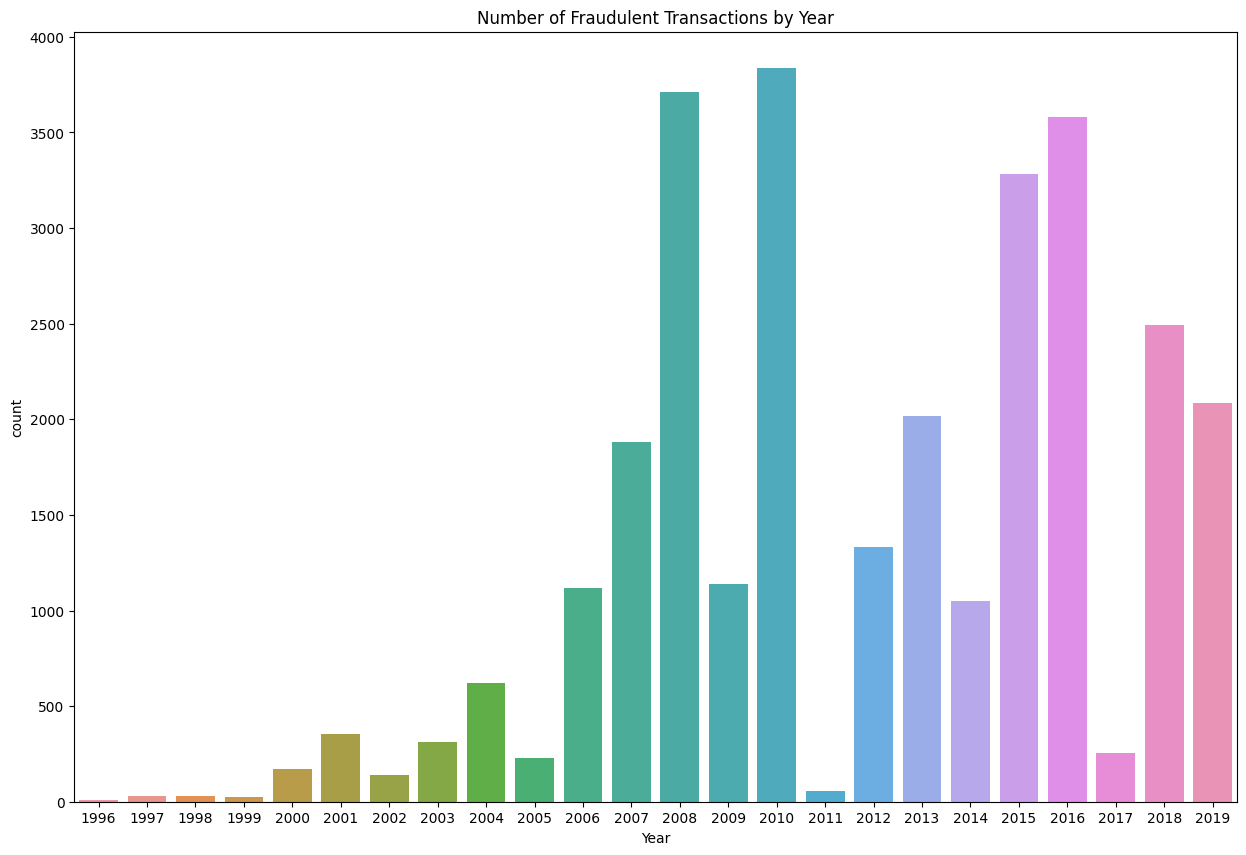

In [17]:
plt.figure(figsize=(15, 10))
sns.countplot(data=fraud_data, x='Year')
plt.title('Number of Fraudulent Transactions by Year')
plt.show()


Entering the 21st century, the number of fraud cases has been steadily rising year by year, reaching its peak in 2007-2008 during the Great Recession.

**By month**

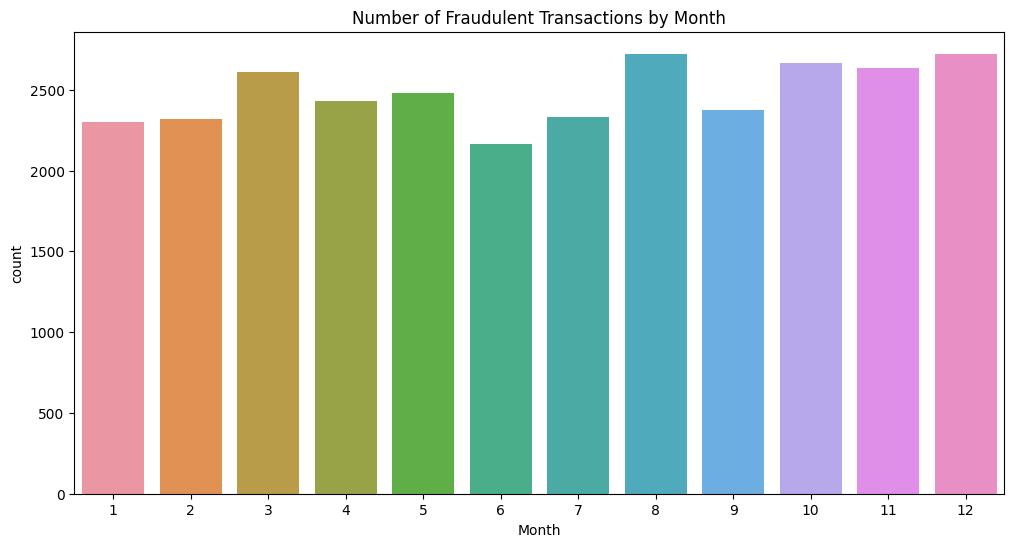

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x='Month')
plt.title('Number of Fraudulent Transactions by Month')
plt.show()


The distribution of fraud cases across months doesn't show significant variations; however, there is a slight uptick in the number of fraud activities towards the end of year.

**By day of month**

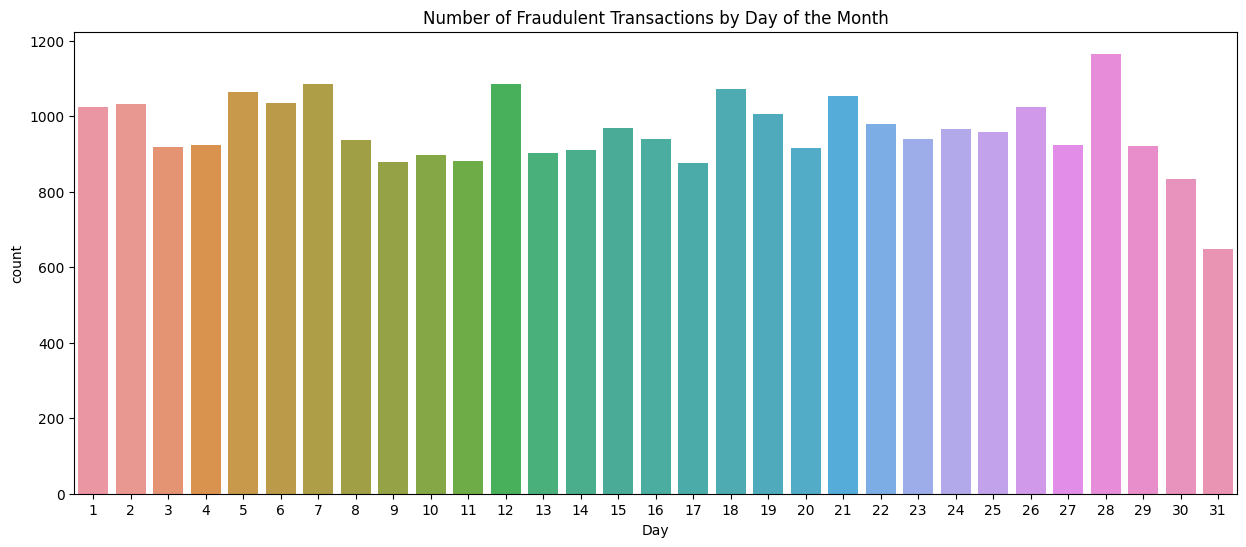

In [19]:
plt.figure(figsize=(15, 6))
sns.countplot(data=fraud_data, x='Day')
plt.title('Number of Fraudulent Transactions by Day of the Month')
plt.show()


The spread of fraud cases over the days of the month remains relatively consistent, but there's a minor increase in fraudulent activities as the month draws to a close.

**By day of week**

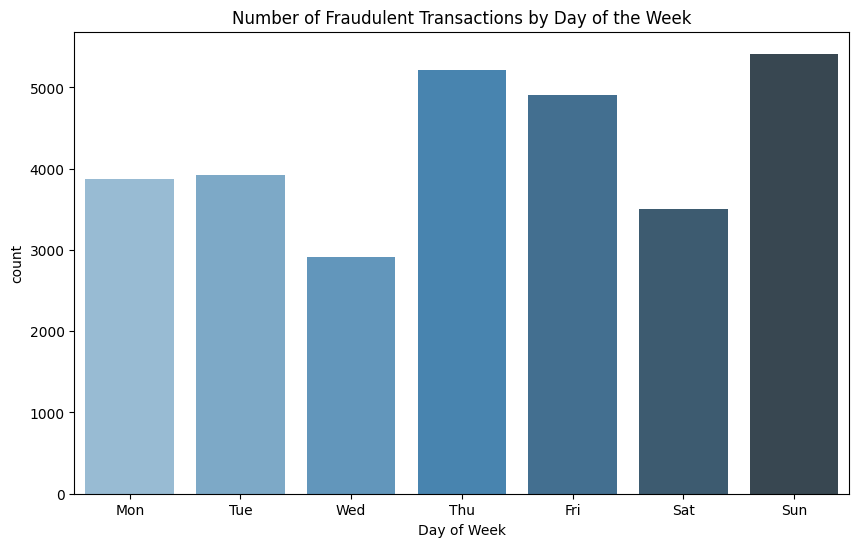

In [20]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Extract day of the week and map it to its name
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['Day of Week'] = df['Date'].dt.dayofweek.map(days)

fraud_data = df[df['Is Fraud?'] == 1]

# Visualize
plt.figure(figsize=(10, 6))
sns.countplot(data=fraud_data, x='Day of Week', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], palette="Blues_d")
plt.title('Number of Fraudulent Transactions by Day of the Week')
plt.show()


A higher number of fraud activities occur on Sundays.

**By hour of day**

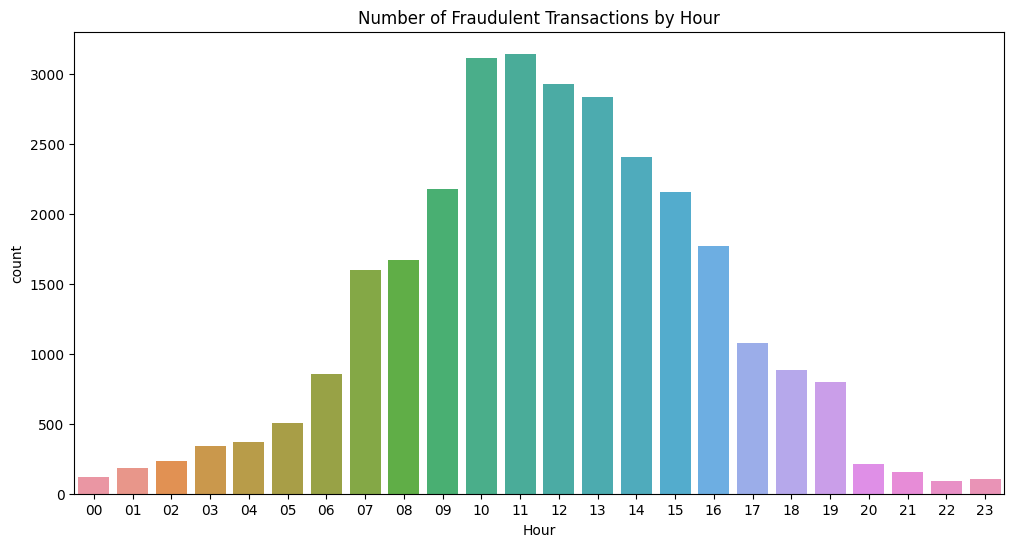

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x='Hour', order=sorted(fraud_data['Hour'].unique()))
plt.title('Number of Fraudulent Transactions by Hour')
plt.show()


Fraud activities predominantly occur between 10 and 11 a.m. local time.

### (4) Transaction Method <a class="anchor"  id="chip"></a>

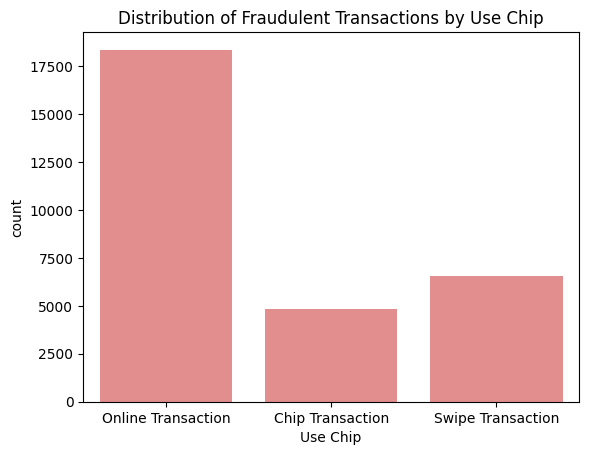

In [22]:
sns.countplot(data=fraud_data, x='Use Chip', color='lightcoral')
plt.title('Distribution of Fraudulent Transactions by Use Chip')
plt.show()


Online transactions present the most significant vulnerability to fraud.

## 4. Fraud Detection with Machine Learning <a class="anchor"  id="ml"></a>

### (1) Data Preprocessing <a class="anchor"  id="data_preprocessing"></a>

Based on the EDA above, we will concentrate on variables that appear to exert a more significant impact on the likelihood of a case being fraudulent. Eliminating the variables with high percentage of missing value, we've chosen the following variables for modelling:

**<span style="color:#007d79;">Year, Day of Week, Hour, Amount, Use Chip, Merchant Name, Merchant City, MCC.</span>** 

In [23]:
# Subset specific columns
columns_to_select = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Is Fraud?']
df = df[columns_to_select]

In [24]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

def clean(df):
    # Convert data type
    df['Hour'] = df['Hour'].astype('float')
    
    # Scale the "Amount" column
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])
   
    # Binary encoding for categorical variables
    cat_col = ['Use Chip', 'Day of Week']
    for col in cat_col:
        if col in df.columns:
            be = ce.BinaryEncoder(drop_invariant=False)
            enc_df = pd.DataFrame(be.fit_transform(df[col]), dtype='int8')
            df = pd.concat([df, enc_df], axis=1)
            df.drop([col], axis=1, inplace=True)
    
    for col in df.columns:
        df[col] = df[col].astype(float)
        
    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)), 
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)


[Pipeline] .......... (step 1 of 1) Processing cleaning, total= 1.4min


### (2) Under sampling

Due to limitation of computational capacity, I subset 40000 data with 20% of them being fraud cases in order to balance the proportion and ensure model performance.

In [25]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df_transformed.drop(columns=['Is Fraud?'])
y = df_transformed['Is Fraud?']

# Calculate the desired number of fraud cases based on the desired proportion
desired_proportion = 0.2
total_samples = 40000
fraud_samples = int(total_samples * desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples}, random_state=1613)

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

### (3) Predictive Modeling with Random Forest <a class="anchor"  id="randomforest"></a>

In [26]:
# Modeling with Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      9608
         1.0       0.93      0.76      0.84      2392

    accuracy                           0.94     12000
   macro avg       0.94      0.87      0.90     12000
weighted avg       0.94      0.94      0.94     12000

[[9477  131]
 [ 582 1810]]


In [27]:
# Hyperparameters Tuning
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Suppress all warnings
warnings.simplefilter("ignore")

# Define the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto' and kept 'sqrt'
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=0, scoring='f1_macro') 

grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best estimator for predictions or further work
best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)

print("Random Forest Classifier Results with Best Hyperparameters:")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Classifier Results with Best Hyperparameters:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      9608
         1.0       0.93      0.78      0.85      2392

    accuracy                           0.94     12000
   macro avg       0.94      0.88      0.91     12000
weighted avg       0.94      0.94      0.94     12000

[[9462  146]
 [ 529 1863]]


**Interpretation:**

1. Precision: A precision of 0.93 for class 1 means that **<span style="color:#007d79;">93%</span>** of the predicted fraud cases were actually fraudulent.

2. Recall: A recall of 0.78 for class 1 means that the model identified **<span style="color:#007d79;">78%</span>** of the actual fraudulent transactions.

3. F1-score: A F1-score of **<span style="color:#007d79;">0.85</span>** indicates a good balance between precision and recall.

In summary, the model achieved high accuracy (93%) and performed well in classifying non-fraudulent transactions (class 0). However, it showed relatively lower recall (78%) for fraudulent transactions (class 1), indicating that it missed some fraudulent cases. Overall, the model demonstrates a good performance but could be further improved to better detect fraud cases.

## 5. Insights & Recommendations <a class="anchor"  id="insights"></a>

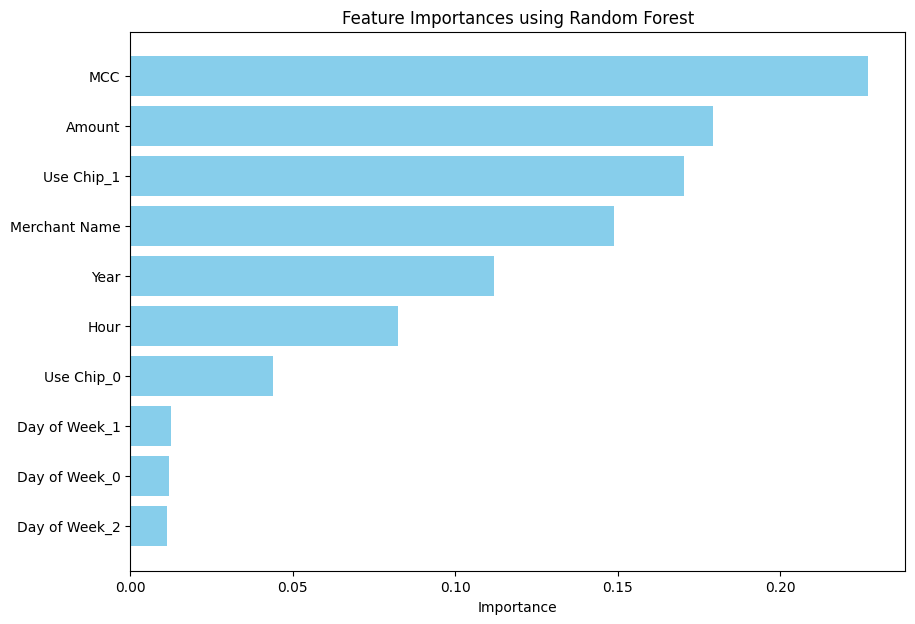

In [28]:
# Extract feature importances from the best random forest model
feature_importance = best_rf.feature_importances_
features = X_train.columns

# Sort the feature importances and their corresponding feature names
sorted_idx = feature_importance.argsort()

# Plot horizontal bar chart
plt.figure(figsize=(10, 7))
plt.barh(features[sorted_idx], feature_importance[sorted_idx], align='center', color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.show()

### Insights 💡
Based on the feature importance scores, the top three most important features for predicting fraud transactions are:

**1. MCC: Merchant Category Code**
- Insight: **<span style="color:#007d79;">Certain types of merchants or industries</span>** may be more susceptible to fraudulent activities than others. It's possible that some categories of businesses are traditionally targeted more by fraudsters because of their transaction volumes, higher ticket items, or perhaps because they offer specific products that are in demand on the black market.

**2. Amount: transaction amount**
- Insight: **<span style="color:#007d79;">The size of a transaction</span>** can be a significant indicator of its likelihood to be fraudulent. Fraudsters might either make very high-value transactions to maximize their gain from a stolen card before it's reported or make very small transactions to fly under the radar and test the card's validity. Therefore, unusually high or low amounts compared to a user's typical transaction patterns can be red flags.

**3. Use Chip_1: Online transactions**
- Insight: **<span style="color:#007d79;">online transactions might be more vulnerable</span>** compared to physical transactions like chip or swipe. This can be attributed to factors like phishing, weak password practices, or compromised databases.

These features have the highest impact on the model's ability to distinguish fraudulent transactions from non-fraudulent ones, which can help banks **<span style="color:#007d79;">prioritize their resources and efforts</span>** in fraud prevention. 

### Recommendations 📓

**1. For MCC:** 
- Businesses and credit card companies should focus on **<span style="color:#007d79;">increasing monitoring and protective measures for merchant categories</span>** that are identified as high risk for fraudulent activities. **<span style="color:#007d79;">User education</span>** for these specific sectors might also be beneficial.



**2. For Amount:** 
- Develop a **<span style="color:#007d79;">dynamic thresholding system</span>** that flags unusually high or low transactions relative to a user's typical transaction profile. Inform users when such anomalies occur.



**3. For Online Transactions:** 
- Encourage users to **<span style="color:#007d79;">adopt secure online transaction practices</span>**, such as frequently updating passwords and avoiding transactions on public Wi-Fi; **<span style="color:#007d79;">Raise awareness</span>** about phishing scams and the importance of ensuring websites are secure (e.g., HTTPS) before inputting card details.